# **Wine Project**

## **Libraries**

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec
import zipfile
import os

# Regular expression
import re

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup
from unidecode import unidecode
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, r2_score
from scipy.stats import zscore

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Configs
pd.set_option('display.max_columns', None)

## **Load Data**

In [57]:
# Reading wine data from zipfile
zip_file_path = 'wine_data.csv.zip'
extraction_directory = ''

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

wine = pd.read_csv('wine_data.csv').dropna(subset=['Name'])

os.remove('wine_data.csv')

wine.head()

,Name,Origin,ProRating,Rating,Price,WineNotes,AlcoholVolume,AlcoholPercent,AuthorName,Review
0,Andreola Col del Forno Prosecco,"Valdobbiadene, Prosecco, Italy",92.0,4.5,25.99,Vines cultivated at over 240 metres above sea ...,750.0,11.5,James Suckling,The aromas of ripe apples and perfumed mineral...
1,Klinker Brick Lodi Farrah Syrah 2018,"Lodi, California",92.0,4.1,13.99,"Dark Garnet in color, the wine gives aromas of...",750.0,15.2,Wine Enthusiast,Superrich fruit and oak flavors are carried on...
2,Matsu El Recio 2021,"Toro, Spain",92.0,4.9,25.99,"Intense ruby red color. On the nose, it has an...",750.0,14.5,James Suckling,"Spiced blackberries, blueberries and hazelnuts..."
3,Scott Harvey Mountain Selection Zinfandel 2020,"Amador, Sierra Foothills, California",93.0,4.5,23.99,The 2020 Mountain Selection Zinfandel is fruit...,NaN,NaN,Wilfred Wong of Wine.com,COMMENTARY: The 2020 Scott Harvey Mountain Sel...
4,Alexander Valley Vineyards Homestead Red 2020,"Alexander Valley, Sonoma County, California",92.0,3.9,21.99,This dark purple wine has complex aromas of bl...,NaN,NaN,Tasting Panel,"First made in 2009, this wine exhibits full ri..."


In [58]:
# Dataset information
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454514 entries, 0 to 454513
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Name            454514 non-null  object 
 1   Origin          454050 non-null  object 
 2   ProRating       116838 non-null  float64
 3   Rating          454514 non-null  float64
 4   Price           454514 non-null  float64
 5   WineNotes       23300 non-null   object 
 6   AlcoholVolume   13192 non-null   float64
 7   AlcoholPercent  13192 non-null   float64
 8   AuthorName      13885 non-null   object 
 9   Review          13812 non-null   object 
dtypes: float64(5), object(5)
memory usage: 38.1+ MB


In [59]:
# Statistic
wine.describe()

,ProRating,Rating,Price,AlcoholVolume,AlcoholPercent
count,116838.000000,454514.000000,454514.000000,13192.000000,13192.000000
mean,92.553133,0.449852,58.711731,740.501213,10.468735
std,2.677261,1.276807,222.877811,247.211916,5.875002
min,12.000000,0.000000,0.000000,0.000000,0.000000
25%,91.000000,0.000000,15.990000,750.000000,11.000000
50%,92.000000,0.000000,25.990000,750.000000,13.200000
75%,94.000000,0.000000,49.990000,750.000000,14.100000
max,100.000000,5.000000,29999.970000,6000.000000,21.500000


In [60]:
# Nulls
wine.isnull().sum()

Name                   0
Origin               464
ProRating         337676
Rating                 0
Price                  0
WineNotes         431214
AlcoholVolume     441322
AlcoholPercent    441322
AuthorName        440629
Review            440702
dtype: int64

## **Data Cleaning and Preprocessing**

First, we have to separate the origin of the wine to country, state, city.

In [61]:
# Convert the row to a Series
def split_origin(row):
    return pd.Series(row['Origin_list'])

# Copy of wine
wine1 = wine.copy()

# Drop rows that contain NAs in Origin
wine1 = wine1.dropna(subset=['Origin'])

# Split items
wine1['Origin_split'] = wine1['Origin'].str.split(',')

# Reverse the list to make it Country, State, City...
wine1['Origin_list'] = wine1['Origin_split'].apply(lambda x: x[::-1])

# Split the Origins by rows and insert it as columns
origin_split = wine1.apply(split_origin, axis=1).rename(columns=lambda x : f"Origin_{x+1}")

# Combine columns of origin_split and drop the columns Origin and Origin_list
wine1 = pd.concat([wine1, origin_split], axis=1).drop(['Origin', 'Origin_list', 'Origin_split'], axis=1)

# Strip whitespaces from first 3 origin columns
wine1['Origin_1'] = wine1['Origin_1'].str.rstrip().str.lstrip()
wine1['Origin_2'] = wine1['Origin_2'].str.rstrip().str.lstrip()
wine1['Origin_3'] = wine1['Origin_3'].str.rstrip().str.lstrip()

wine1.head()

,Name,ProRating,Rating,Price,WineNotes,AlcoholVolume,AlcoholPercent,AuthorName,Review,Origin_1,Origin_2,Origin_3,Origin_4,Origin_5
0,Andreola Col del Forno Prosecco,92.0,4.5,25.99,Vines cultivated at over 240 metres above sea ...,750.0,11.5,James Suckling,The aromas of ripe apples and perfumed mineral...,Italy,Prosecco,Valdobbiadene,NaN,NaN
1,Klinker Brick Lodi Farrah Syrah 2018,92.0,4.1,13.99,"Dark Garnet in color, the wine gives aromas of...",750.0,15.2,Wine Enthusiast,Superrich fruit and oak flavors are carried on...,California,Lodi,NaN,NaN,NaN
2,Matsu El Recio 2021,92.0,4.9,25.99,"Intense ruby red color. On the nose, it has an...",750.0,14.5,James Suckling,"Spiced blackberries, blueberries and hazelnuts...",Spain,Toro,NaN,NaN,NaN
3,Scott Harvey Mountain Selection Zinfandel 2020,93.0,4.5,23.99,The 2020 Mountain Selection Zinfandel is fruit...,NaN,NaN,Wilfred Wong of Wine.com,COMMENTARY: The 2020 Scott Harvey Mountain Sel...,California,Sierra Foothills,Amador,NaN,NaN
4,Alexander Valley Vineyards Homestead Red 2020,92.0,3.9,21.99,This dark purple wine has complex aromas of bl...,NaN,NaN,Tasting Panel,"First made in 2009, this wine exhibits full ri...",California,Sonoma County,Alexander Valley,NaN,NaN


Some data in Origin_1 doesn't correspond to the Country, for example instead of having US in Origin_1, it contains the name of the state which is California, so we have to clean it. And other country names that have inconsistencies.

In [62]:
wine1['Origin_1'].unique()

array(['Italy', 'California', 'Spain', 'France', 'Australia', 'Germany',
       'New Zealand', 'Croatia', 'South Africa', 'Hungary', 'Portugal',
       'Argentina', 'Austria', 'Chile', 'Washington', 'England', 'Oregon',
       'Israel', 'Slovenia', 'Other U.S.', 'Armenia', 'Mexico', 'Greece',
       'Uruguay', 'Macedonia (FYROM)', 'Lebanon', 'Brazil', 'Other',
       'China', 'Canada', 'Switzerland', 'Turkey', 'Japan',
       'Country of Georgia', 'Moldova', 'South America', 'Romania',
       'Bulgaria', 'Peru', 'Cyprus', 'Colombia'], dtype=object)

In [63]:
# Copy of wine1
wine2 = wine1.copy()

# Function for the cleaning
def clean_origin_cols(row):
    row2 = row.copy()
    if row['Origin_1'] in ['California', 'Oregon', 'Washington']:
        for i in range(-5, 0, 1):
            if i < 0 and i+1 < 0:
                row.iloc[i+1] = row2.iloc[i]
        row.iloc[-5] = 'United States'
    elif row['Origin_1'] == 'Other U.S.':
        row['Origin_1'] = 'United States'
    elif row['Origin_1'] == 'Macedonia (FYROM)':
        row['Origin_1'] = 'Macedonia'
    elif row['Origin_1'] == 'Country of Georgia':
        row['Origin_1'] = 'Georgia'
    return row

# Apply the function and rename the columns
wine2 = wine2.apply(clean_origin_cols, axis=1).rename(columns={'Origin_1':'Country', 'Origin_2':'Region'})

wine2.head()

,Name,ProRating,Rating,Price,WineNotes,AlcoholVolume,AlcoholPercent,AuthorName,Review,Country,Region,Origin_3,Origin_4,Origin_5
0,Andreola Col del Forno Prosecco,92.0,4.5,25.99,Vines cultivated at over 240 metres above sea ...,750.0,11.5,James Suckling,The aromas of ripe apples and perfumed mineral...,Italy,Prosecco,Valdobbiadene,NaN,NaN
1,Klinker Brick Lodi Farrah Syrah 2018,92.0,4.1,13.99,"Dark Garnet in color, the wine gives aromas of...",750.0,15.2,Wine Enthusiast,Superrich fruit and oak flavors are carried on...,United States,California,Lodi,NaN,NaN
2,Matsu El Recio 2021,92.0,4.9,25.99,"Intense ruby red color. On the nose, it has an...",750.0,14.5,James Suckling,"Spiced blackberries, blueberries and hazelnuts...",Spain,Toro,NaN,NaN,NaN
3,Scott Harvey Mountain Selection Zinfandel 2020,93.0,4.5,23.99,The 2020 Mountain Selection Zinfandel is fruit...,NaN,NaN,Wilfred Wong of Wine.com,COMMENTARY: The 2020 Scott Harvey Mountain Sel...,United States,California,Sierra Foothills,Amador,NaN
4,Alexander Valley Vineyards Homestead Red 2020,92.0,3.9,21.99,This dark purple wine has complex aromas of bl...,NaN,NaN,Tasting Panel,"First made in 2009, this wine exhibits full ri...",United States,California,Sonoma County,Alexander Valley,NaN


In [64]:
# Copy of wine2
wine3 = wine2.copy()

# Replace values 0 to NA
wine3['Rating'].replace(0, np.nan, inplace=True)
wine3['Price'].replace(0, np.nan, inplace=True)
wine3['AlcoholVolume'].replace(0, np.nan, inplace=True)

In [65]:
# Copy of wine3
wine4 = wine3.copy()

# Function for cleaning text
def clean_text(text):     
    # Return NA if there's no review or winenotes
    if pd.isna(text):
        return np.nan
    
    else:
        # Remove 'COMMENTARY:' and 'TASTING NOTES:'
        removed = re.sub(r'(COMMENTARY|TASTING NOTES)', '',text)

        # Replace the symbol '%' with its textual representation
        replace_percentage = removed.replace('%', ' percent')

        # Strip symbols
        no_symbols = re.sub(r'[^\w\s]', ' ', replace_percentage)

        # Remove accented characters
        no_accented = ''.join([char for char in no_symbols if char.isascii()])

        # Clean text in lower case
        cleaned_text = no_accented.lower()
     
        return cleaned_text

# Clean text
wine4['Cleaned_review'] = wine4['Review'].apply(clean_text)
wine4['Cleaned_winenotes'] = wine4['WineNotes'].apply(clean_text)

wine4.head()

,Name,ProRating,Rating,Price,WineNotes,AlcoholVolume,AlcoholPercent,AuthorName,Review,Country,Region,Origin_3,Origin_4,Origin_5,Cleaned_review,Cleaned_winenotes
0,Andreola Col del Forno Prosecco,92.0,4.5,25.99,Vines cultivated at over 240 metres above sea ...,750.0,11.5,James Suckling,The aromas of ripe apples and perfumed mineral...,Italy,Prosecco,Valdobbiadene,NaN,NaN,the aromas of ripe apples and perfumed mineral...,vines cultivated at over 240 metres above sea ...
1,Klinker Brick Lodi Farrah Syrah 2018,92.0,4.1,13.99,"Dark Garnet in color, the wine gives aromas of...",750.0,15.2,Wine Enthusiast,Superrich fruit and oak flavors are carried on...,United States,California,Lodi,NaN,NaN,superrich fruit and oak flavors are carried on...,dark garnet in color the wine gives aromas of...
2,Matsu El Recio 2021,92.0,4.9,25.99,"Intense ruby red color. On the nose, it has an...",750.0,14.5,James Suckling,"Spiced blackberries, blueberries and hazelnuts...",Spain,Toro,NaN,NaN,NaN,spiced blackberries blueberries and hazelnuts...,intense ruby red color on the nose it has an...
3,Scott Harvey Mountain Selection Zinfandel 2020,93.0,4.5,23.99,The 2020 Mountain Selection Zinfandel is fruit...,NaN,NaN,Wilfred Wong of Wine.com,COMMENTARY: The 2020 Scott Harvey Mountain Sel...,United States,California,Sierra Foothills,Amador,NaN,the 2020 scott harvey mountain selection zin...,the 2020 mountain selection zinfandel is fruit...
4,Alexander Valley Vineyards Homestead Red 2020,92.0,3.9,21.99,This dark purple wine has complex aromas of bl...,NaN,NaN,Tasting Panel,"First made in 2009, this wine exhibits full ri...",United States,California,Sonoma County,Alexander Valley,NaN,first made in 2009 this wine exhibits full ri...,this dark purple wine has complex aromas of bl...


In [66]:
# Drop columns and duplicated values
wine5 = wine4.copy()
wine5.drop(columns=['Review', 'WineNotes'], axis=1, inplace=True)
wine5.drop_duplicates(subset='Name', inplace=True)
wine5.head()

,Name,ProRating,Rating,Price,AlcoholVolume,AlcoholPercent,AuthorName,Country,Region,Origin_3,Origin_4,Origin_5,Cleaned_review,Cleaned_winenotes
0,Andreola Col del Forno Prosecco,92.0,4.5,25.99,750.0,11.5,James Suckling,Italy,Prosecco,Valdobbiadene,NaN,NaN,the aromas of ripe apples and perfumed mineral...,vines cultivated at over 240 metres above sea ...
1,Klinker Brick Lodi Farrah Syrah 2018,92.0,4.1,13.99,750.0,15.2,Wine Enthusiast,United States,California,Lodi,NaN,NaN,superrich fruit and oak flavors are carried on...,dark garnet in color the wine gives aromas of...
2,Matsu El Recio 2021,92.0,4.9,25.99,750.0,14.5,James Suckling,Spain,Toro,NaN,NaN,NaN,spiced blackberries blueberries and hazelnuts...,intense ruby red color on the nose it has an...
3,Scott Harvey Mountain Selection Zinfandel 2020,93.0,4.5,23.99,NaN,NaN,Wilfred Wong of Wine.com,United States,California,Sierra Foothills,Amador,NaN,the 2020 scott harvey mountain selection zin...,the 2020 mountain selection zinfandel is fruit...
4,Alexander Valley Vineyards Homestead Red 2020,92.0,3.9,21.99,NaN,NaN,Tasting Panel,United States,California,Sonoma County,Alexander Valley,NaN,first made in 2009 this wine exhibits full ri...,this dark purple wine has complex aromas of bl...


In [67]:
# Information of the cleaned dataframe
winedf = wine5
winedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341899 entries, 0 to 454512
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Name               341899 non-null  object 
 1   ProRating          87239 non-null   float64
 2   Rating             38320 non-null   float64
 3   Price              341851 non-null  float64
 4   AlcoholVolume      8496 non-null    float64
 5   AlcoholPercent     8514 non-null    float64
 6   AuthorName         8761 non-null    object 
 7   Country            341899 non-null  object 
 8   Region             313137 non-null  object 
 9   Origin_3           205967 non-null  object 
 10  Origin_4           87196 non-null   object 
 11  Origin_5           25691 non-null   object 
 12  Cleaned_review     13796 non-null   object 
 13  Cleaned_winenotes  15535 non-null   object 
dtypes: float64(5), object(9)
memory usage: 39.1+ MB


## **EDA**

### Numerical values
- ProRating
- Rating
- Price
- AlcoholVolume
- AlcoholPercent

In [68]:
# Create variable with numerical columns
num_cols = ['ProRating', 'Rating', 'Price', 'AlcoholVolume', 'AlcoholPercent']

In [69]:
# Statistics of numerical values
winedf.describe()

,ProRating,Rating,Price,AlcoholVolume,AlcoholPercent
count,87239.000000,38320.000000,341851.000000,8496.000000,8514.000000
mean,92.544344,4.024546,58.317167,759.578978,10.911543
std,2.671179,0.443312,224.629161,174.793043,5.524372
min,12.000000,1.300000,0.990000,187.000000,0.000000
25%,91.000000,3.800000,15.990000,750.000000,12.000000
50%,92.000000,4.000000,25.990000,750.000000,13.400000
75%,94.000000,4.300000,49.990000,750.000000,14.100000
max,100.000000,5.000000,29999.970000,6000.000000,21.500000


#### Correlation Matrix

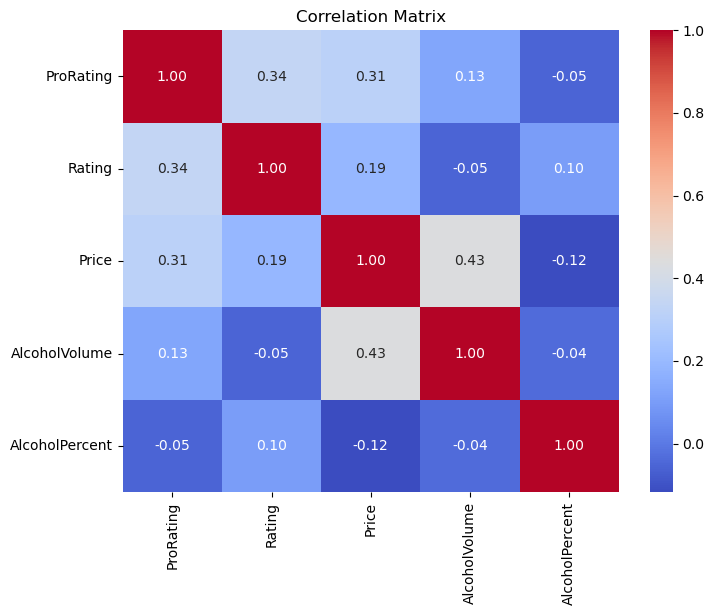

In [70]:
# Correlation matrix
correlation_matrix = winedf.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Boxplots

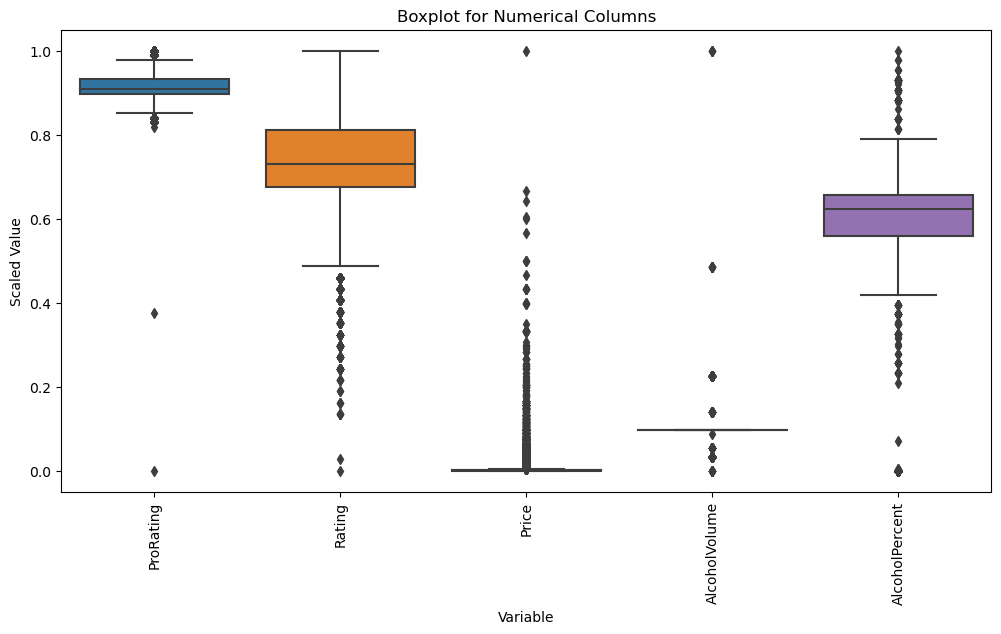

In [71]:
# Extract numerical features
num_data = winedf[num_cols]

# MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(num_data)

# Create DF from the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=num_cols)

# Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)
plt.title('Boxplot for Numerical Columns')
plt.ylabel('Scaled Value')
plt.xlabel('Variable')
plt.show()


#### Histograms

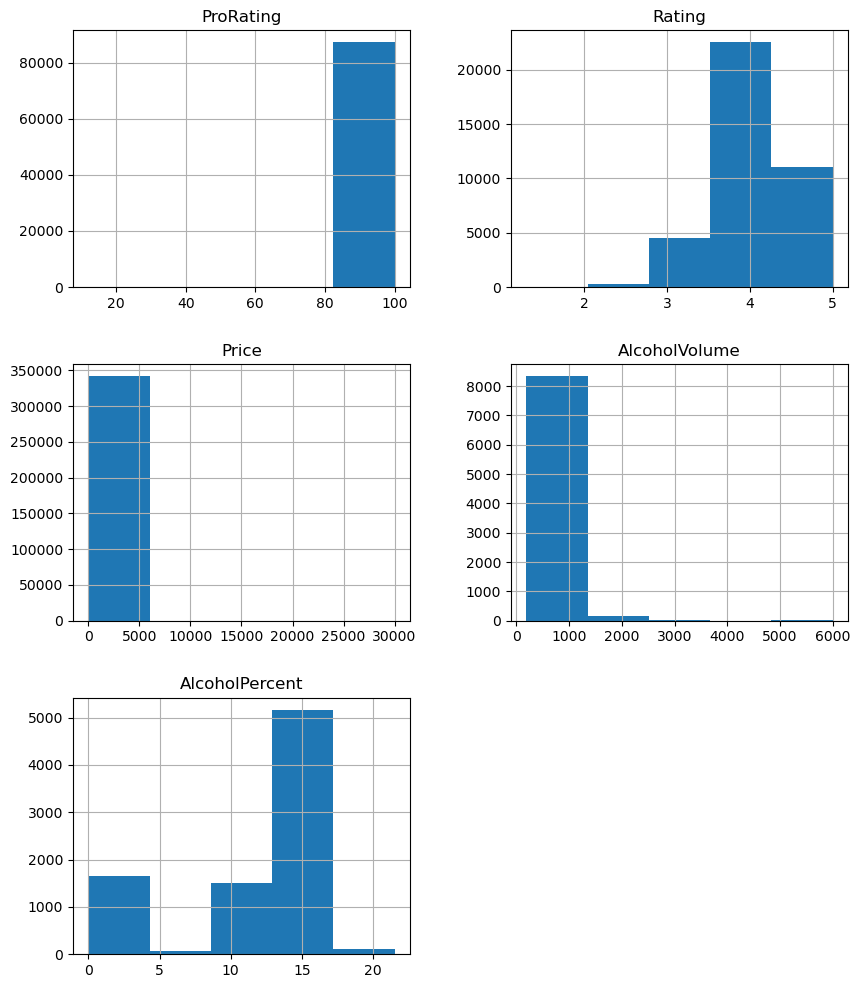

In [72]:
# Histograms for numerical data
winedf[num_cols].hist(figsize=(10,12), bins=5);

### Categorical values
- AuthorName
- Country
- Region

In [73]:
# Columns of categorical values
cat_cols = ['AuthorName', 'Country', 'Region']

#### Authors

In [74]:
# Count of authors
winedf['AuthorName'].value_counts()

James Suckling                   1844
Robert Parker's Wine Advocate    1351
Wine Enthusiast                  1241
Wine Spectator                   1239
Wilfred Wong of Wine.com          632
Jeb Dunnuck                       576
Decanter                          459
Vinous                            450
Wine & Spirits                    301
Burghound.com                     287
Tasting Panel                     183
Jasper Morris                     141
Connoisseurs' Guide                32
Australian Wine Companion          17
The Somm Journal                    8
Name: AuthorName, dtype: int64

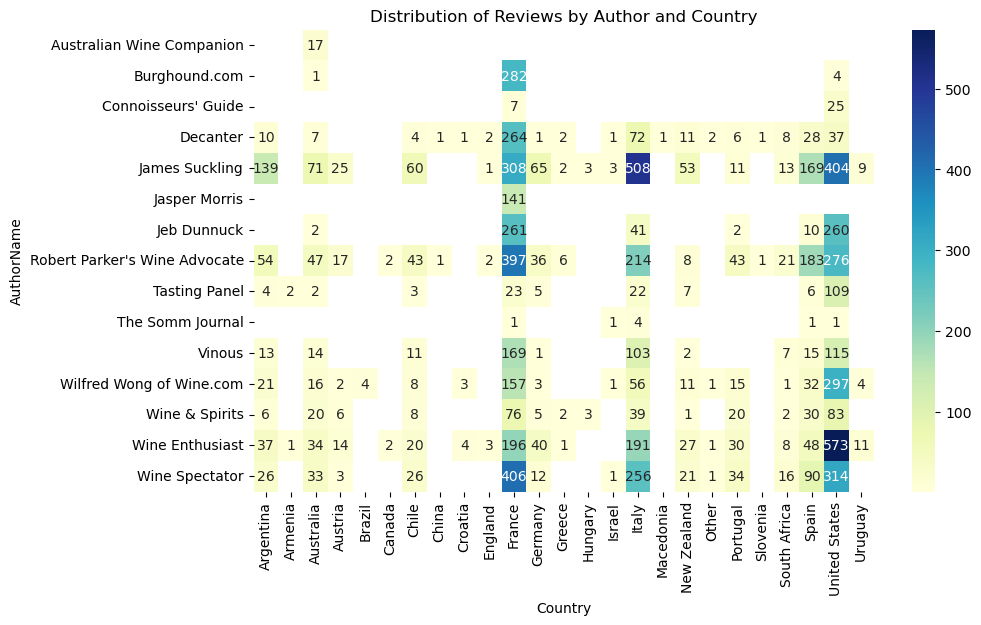

In [75]:
# Authors per country
pivot_table = winedf.pivot_table(index='AuthorName', columns='Country', values='Cleaned_review', aggfunc = lambda x: len(x))

# Creating the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt="g")
plt.title('Distribution of Reviews by Author and Country')
plt.show()

#### Country

In [76]:
# Counts of each country
winedf['Country'].value_counts()

United States    131933
France            73127
Italy             52131
Spain             20429
Australia         15113
Argentina          8967
South Africa       8081
Chile              7608
New Zealand        6344
Portugal           5139
Austria            4236
Germany            2865
Greece             1453
Israel             1419
Hungary             626
Other               343
Canada              303
Slovenia            300
Mexico              243
Croatia             186
Switzerland         175
Uruguay             125
Turkey              123
South America       123
Georgia             111
Lebanon             104
Japan               101
England              57
Moldova              45
Macedonia            28
Armenia              20
Brazil               15
Bulgaria              8
Cyprus                6
China                 5
Peru                  3
Romania               3
Colombia              1
Name: Country, dtype: int64

In [77]:
# Average Rating, ProRating and Price for each country
average_data = winedf.groupby('Country')[['Rating','ProRating', 'Price']].mean()
average_data['Count'] = winedf.groupby('Country')['Price'].count()
average_data.sort_values(by='Rating', ascending=False)

,Rating,ProRating,Price,Count
Country,,,,
China,4.800000,95.250000,287.988000,5
Moldova,4.400000,NaN,13.790000,45
Canada,4.318182,92.244444,53.461716,303
England,4.290000,93.266667,102.235789,57
Japan,4.238889,NaN,42.578911,101
Other,4.233333,94.285714,30.607609,343
Armenia,4.225000,91.777778,38.990000,20
Hungary,4.180000,93.327869,50.720575,626
Turkey,4.150000,90.000000,20.884309,123


#### Region

In [78]:
# Count of region
region_counts = winedf.groupby(['Country', 'Region']).size().reset_index(name='Count')
region_counts.sort_values(by='Count', ascending=False)

,Country,Region,Count
148,United States,California,104291
31,France,Burgundy,32098
74,Italy,Tuscany,14774
68,Italy,Piedmont,12230
169,United States,Washington,11902
...,...,...,...
142,Spain,Utiel-Requena,2
34,France,Dordogne,2
79,Japan,Hiroshima,1
88,Japan,Tochigi,1


In [79]:
# Mean rating and price per region
mean_data_per_region = winedf.groupby(['Country', 'Region'])[['Rating', 'Price']].mean()
mean_data_per_region.sort_values(by='Rating', ascending=False)

Rating      Price
Country       Region                            
United States Michigan       4.725000  20.116394
Italy         Valle d'Aosta  4.677778  24.468777
United States Florida        4.600000  11.490000
Spain         Somontano      4.585714  14.037870
Japan         Hokkaido       4.550000  22.990000
...                               ...        ...
United States Missouri            NaN  18.374615
              New Jersey          NaN  18.971927
              Ohio                NaN  15.643265
              Pennsylvania        NaN  18.586491
              Wisconsin           NaN  18.370952

[171 rows x 2 columns]

### Wordcloud for wines that have high ratings and price

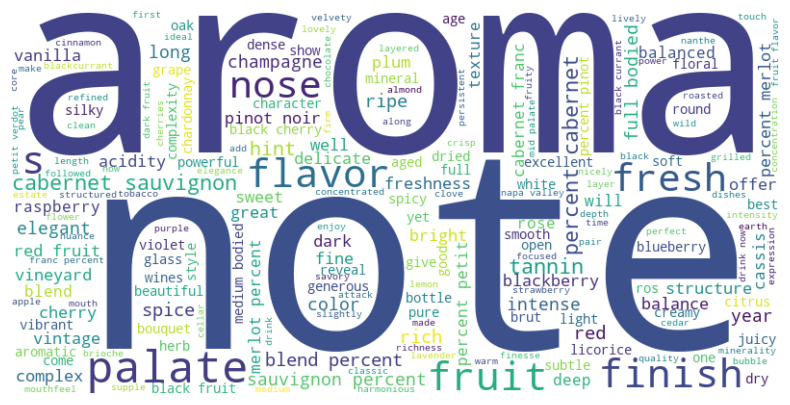

In [80]:

#filter for high ratings/price
q3points = winedf["Rating"].quantile(0.75)
q3price = winedf["Price"].quantile(0.75)

highpriceandpoints = winedf[(winedf["Price"]>= q3price) & (winedf["Rating"] >= q3points)]
highpriceandpoints
highpriceandpointstext = ""

for index, row in highpriceandpoints.iterrows():
    highpriceandpointstext += str(row["Cleaned_review"])
    highpriceandpointstext += str(row["Cleaned_winenotes"])

    
    
    
# Create a WordCloud object
custom_stopwords = STOPWORDS.union({"wine"})
wordcloud = WordCloud(stopwords = custom_stopwords, width=800, height=400, background_color='white').generate(highpriceandpointstext)
# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Words that are highly correlated to a high price/rating

In [81]:
winedf["Cleaned_description"] = winedf["Cleaned_review"] + winedf["Cleaned_winenotes"]

#filter for rows with non nan values in all 3 columns
winedf_nonan = winedf.dropna(subset=['Price', 'Rating', 'Cleaned_description'])


custom_stopwords = set(stopwords.words("english"))
custom_stopwords_list = list(custom_stopwords)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words=custom_stopwords_list)  # You can adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(winedf_nonan["Cleaned_description"])

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

#Standardize the 'points' and 'price' columns
scaler = StandardScaler()
winedf_nonan['Rating_scaled'] = scaler.fit_transform(winedf_nonan[['Rating']])
winedf_nonan['Price_scaled'] = scaler.fit_transform(winedf_nonan[["Price"]])
winedf_nonan.reset_index(drop=True, inplace=True)

# # Concatenate the TF-IDF features with the scaled 'points' and 'price' columns
wine_features_df = pd.concat([tfidf_df, winedf_nonan[['Rating_scaled', 'Price_scaled']]], axis=1)

# # Calculate correlations
correlations = wine_features_df.corr()

# Find important features correlated with 'points' and 'price'
important_features_points = correlations['Rating_scaled'].sort_values(ascending=False)
important_features_price = correlations['Price_scaled'].sort_values(ascending=False)

print("Attributes correlated with 'points':")
print(important_features_points.head(15))

print("\nAttributes correlated with 'price':")
print(important_features_price.head(15))

Attributes correlated with 'points':
Rating_scaled    1.000000
Price_scaled     0.365665
cabernet         0.070763
full             0.052596
sauvignon        0.049052
blackberry       0.047012
color            0.042839
deep             0.042795
palate           0.035801
spices           0.034414
mouth            0.033380
sweet            0.031965
merlot           0.031881
ruby             0.031439
intense          0.029876
Name: Rating_scaled, dtype: float64

Attributes correlated with 'price':
Price_scaled     1.000000
Rating_scaled    0.365665
cabernet         0.137106
merlot           0.087415
sauvignon        0.073629
percent          0.064525
years            0.060243
complex          0.059386
vintage          0.058742
structure        0.045927
tannins          0.045813
blend            0.041500
long             0.040773
deep             0.037716
fine             0.034224
Name: Price_scaled, dtype: float64


### Conclusion
- There's no correlation between the numerical data, the only correlation that it's "high" is the price with the alcohol volume.
- There're a lot of outliers in all numerical data, for the model training we should remove them for a better performance.
- With the histogram we can see which data we should include in our data for the training.

## Unsupervised Learning

### Winenotes VS Price

In [82]:
new_stopwords = ['wine', 'drink', 'percent']
all_stopwords = list(set(stopwords.words('english') + new_stopwords))

data = winedf['Cleaned_winenotes'].dropna()

# Define a custom tokenizer that excludes tokens containing numbers
def custom_tokenizer(text):
    tokens = text.split()
    return [token for token in tokens if not any(char.isdigit() for char in token)]

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=all_stopwords, ngram_range=(2,2))
X = tfidf_vectorizer.fit_transform(data)

number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(number_of_clusters):
    print('Cluster %d:' %i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 pinot noir
 blend pinot
 blend chardonnay
 chardonnay pinot
 noir chardonnay
 pinot meunier
 red fruit
 valley pinot
 black cherry
 russian river
Cluster 1:
 cabernet franc
 merlot cabernet
 cabernet sauvignon
 blend cabernet
 blend merlot
 sauvignon merlot
 petit verdot
 franc cabernet
 merlot petit
 franc petit
Cluster 2:
 cabernet sauvignon
 full bodied
 ruby red
 red color
 red fruit
 black cherry
 red fruits
 long finish
 well balanced
 blend cabernet


In [83]:
columns = ['Cleaned_winenotes']
df = winedf.dropna(subset=columns)

preprocessor = ColumnTransformer([
    ('Cleaned_winenotes', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=all_stopwords, ngram_range=(2,2)), 'Cleaned_winenotes')
],
verbose=True)

cluster = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=number_of_clusters, random_state=0))
])

df['cluster_winenotes'] = cluster.fit_predict(df[columns])

df.groupby('cluster_winenotes').describe(include=np.number)

[ColumnTransformer]  (1 of 1) Processing Cleaned_winenotes, total=   0.9s


ProRating                                                \
                      count       mean       std   min    25%   50%   75%   
cluster_winenotes                                                           
0                    7066.0  92.624399  2.228337  88.0  91.00  92.0  94.0   
1                     140.0  96.314286  2.411262  91.0  94.75  96.0  98.0   
2                     780.0  93.751282  2.669600  88.0  92.00  93.0  96.0   

                          Rating                                            \
                     max   count      mean       std  min  25%  50%    75%   
cluster_winenotes                                                            
0                  100.0  3986.0  3.944104  0.409114  1.9  3.7  3.9  4.200   
1                  100.0    34.0  4.238235  0.364330  3.5  4.0  4.2  4.475   
2                  100.0   415.0  4.084337  0.370234  2.8  3.8  4.1  4.300   

                          Price                                               \
                   max    count        mean         std    min    25%    50%   
cluster_winenotes                                                              
0                  5.0  14162.0   57.208986  173.216175   5.97  19.99  28.99   
1                  5.0    143.0  228.251469  317.275493  17.99  44.98  99.97   
2                  5.0   1230.0  106.646724  244.619679   7.99  21.99  42.99   

                                    AlcoholVolume                          \
                      75%       max         count        mean         std   
cluster_winenotes                                                           
0                   53.99  12999.97        7144.0  754.340426  146.720894   
1                  241.97   1529.97          71.0  813.380282  210.094833   
2                   99.99   4263.97         623.0  783.306581  281.289916   

                                                      AlcoholPercent  \
                     min    25%    50%    75%     max          count   
cluster_winenotes                                                      
0                  187.0  750.0  750.0  750.0  6000.0         7161.0   
1                  750.0  750.0  750.0  750.0  1500.0           71.0   
2                  375.0  750.0  750.0  750.0  6000.0          624.0   

                                                                      
                        mean       std  min    25%   50%   75%   max  
cluster_winenotes                                                     
0                  11.368432  5.093710  0.0  12.00  13.4  14.0  21.5  
1                  11.185211  5.621542  0.0  12.65  13.7  14.5  15.6  
2                  12.165481  5.157798  0.0  13.50  14.4  14.5  15.7

In [84]:
df['cluster_winenotes']= df['cluster_winenotes'].astype(str)
df['cluster_winenotes'].replace({'0':'Low-priced', '1':'High-priced', '2':'Mid-priced'}, inplace=True)

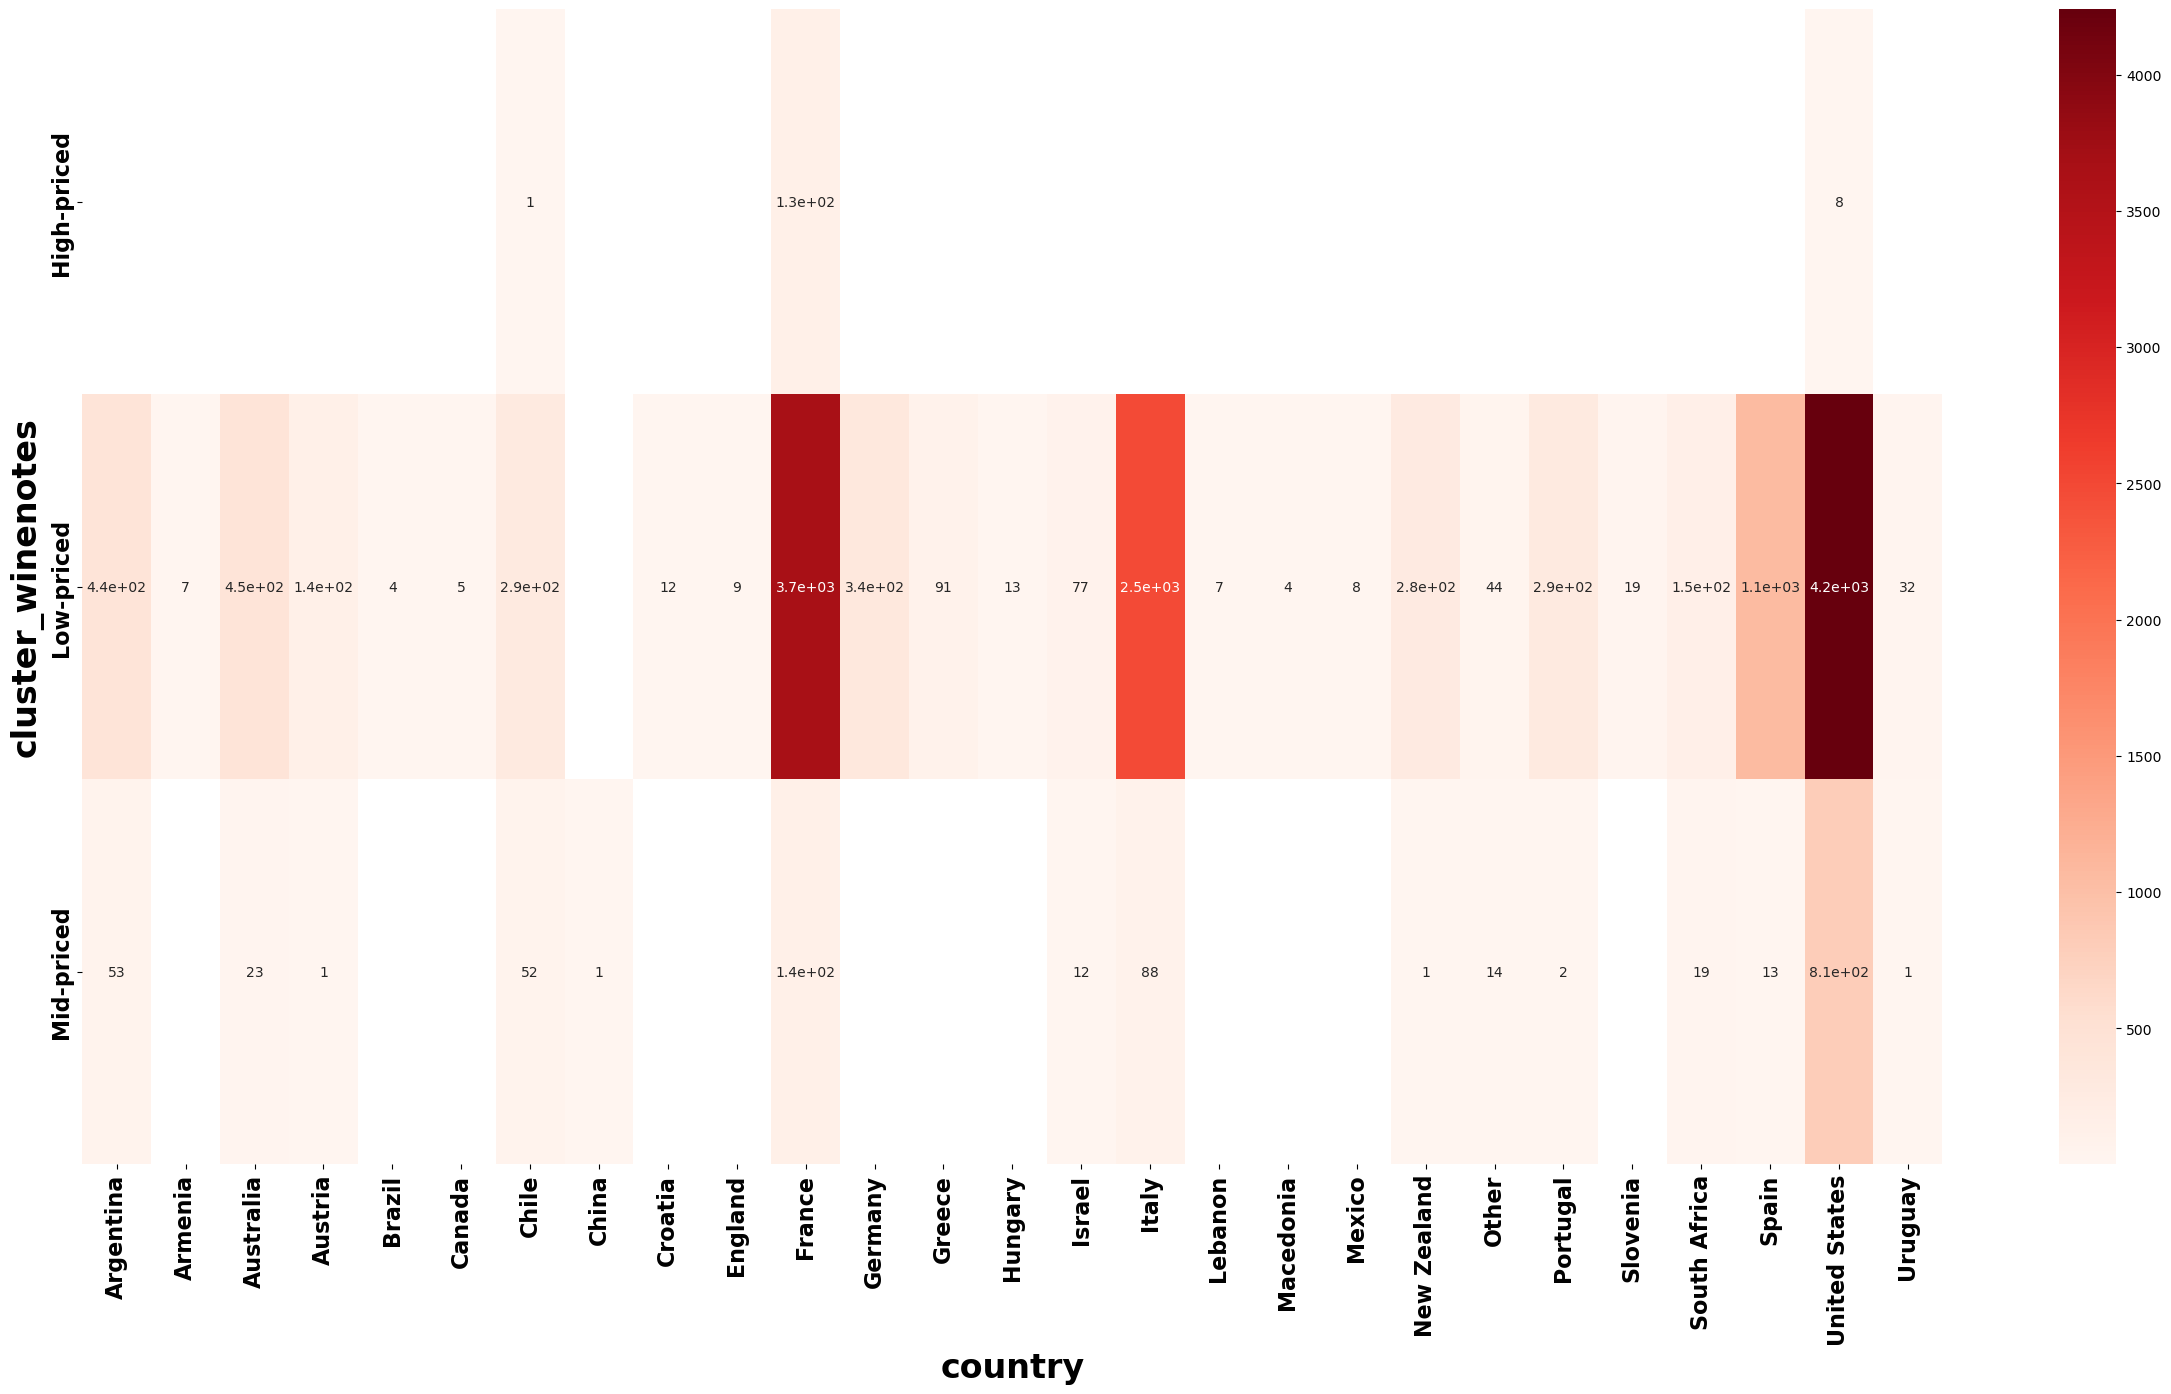

In [85]:
clusters = df.groupby(['cluster_winenotes', 'Country']).size()
fig2, ax2 = plt.subplots(figsize=(30,15))
sns.heatmap(clusters.unstack(level='Country'), ax=ax2, cmap='Reds', annot=True)

ax2.set_xlabel('country', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster_winenotes', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

              precision    recall  f1-score   support

 High-priced       0.76      1.00      0.87        29
  Low-priced       1.00      0.85      0.92      2832
  Mid-priced       0.35      0.96      0.52       246

    accuracy                           0.86      3107
   macro avg       0.70      0.93      0.77      3107
weighted avg       0.94      0.86      0.88      3107



<Figure size 800x500 with 0 Axes>

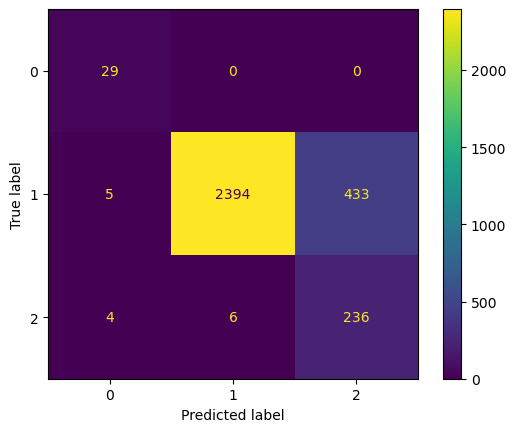

In [86]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Selecting data
exp_df = df[['Cleaned_winenotes', 'cluster_winenotes']]

# Dividing data into features and target
X = exp_df.iloc[:, :-1]
y = exp_df.iloc[:, -1]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.20)

# Creating preprocessor
preprocessor = ColumnTransformer([
    ('Cleaned_winenotes', TfidfVectorizer(ngram_range=(2,2)), 'Cleaned_winenotes')
], remainder='passthrough')

# Creating pipeline for imbalanced classes
clf = ImbalancedPipeline([
    ('preprocessor', preprocessor),
    ('over_sampler', SMOTE(sampling_strategy='not majority', random_state=0, k_neighbors=number_of_clusters)),
    ('clf', MultinomialNB())
])

# Training and testing the classifier
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Generating a confusion matrix
plt.figure(figsize=(8,5))
cm = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(cm)
conf_matrix.plot();

### Review VS Rating

In [87]:
new_stopwords = ['wine', 'drink', 'percent']
all_stopwords = list(set(stopwords.words('english') + new_stopwords))

data = winedf['Cleaned_review'].dropna()

# Define a custom tokenizer that excludes tokens containing numbers
def custom_tokenizer(text):
    tokens = text.split()
    return [token for token in tokens if not any(char.isdigit() for char in token)]

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=all_stopwords, ngram_range=(2,2))
X = tfidf_vectorizer.fit_transform(data)

number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(number_of_clusters):
    print('Cluster %d:' %i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 full bodied
 medium full
 cabernet sauvignon
 full body
 bodied palate
 core fruit
 black cherries
 bodied firm
 barrel sample
 chewy tannins
Cluster 1:
 medium bodied
 cabernet sauvignon
 cabernet franc
 petit verdot
 sauvignon merlot
 merlot cabernet
 bodied palate
 blend cabernet
 barrel sample
 nose medium
Cluster 2:
 aromas flavors
 francisco ca
 san francisco
 barrel sample
 medium body
 pinot noir
 black cherry
 red fruit
 orange peel
 black fruit


In [88]:
columns = ['Cleaned_review']
df2 = df.dropna(subset=columns)

preprocessor = ColumnTransformer([
    ('Cleaned_review', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=all_stopwords, ngram_range=(2,2)), 'Cleaned_review')
],
verbose=True)

cluster = Pipeline([
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=number_of_clusters, random_state=0))
])

df2['cluster_review'] = cluster.fit_predict(df2[columns])

df2.groupby('cluster_review').describe(include=np.number)

[ColumnTransformer]  (1 of 1) Processing Cleaned_review, total=   0.6s


ProRating                                                      \
                   count       mean       std   min   25%   50%   75%    max   
cluster_review                                                                 
0                 4372.0  92.401647  2.097089  88.0  91.0  92.0  94.0  100.0   
1                 1275.0  92.434510  2.073849  88.0  91.0  92.0  94.0  100.0   
2                  410.0  92.351220  1.895448  88.0  91.0  92.0  93.0   98.0   

                Rating                                                Price  \
                 count      mean       std  min  25%  50%  75%  max   count   
cluster_review                                                                
0               2687.0  3.921399  0.405087  1.9  3.7  3.9  4.2  5.0  9407.0   
1                710.0  3.951690  0.407498  2.6  3.7  3.9  4.2  5.0  2616.0   
2                255.0  3.903529  0.425870  2.6  3.6  3.9  4.2  5.0   854.0   

                                                                          \
                     mean        std   min    25%    50%    75%      max   
cluster_review                                                             
0               42.676810  79.289013  5.99  18.99  26.99  46.99  5289.99   
1               44.883609  51.981374  7.99  19.99  27.99  49.99  1299.97   
2               42.796663  57.088039  7.99  18.99  26.99  45.99   819.99   

               AlcoholVolume                                              \
                       count        mean        std    min    25%    50%   
cluster_review                                                             
0                     4697.0  750.106238  45.768588  187.0  750.0  750.0   
1                     1311.0  750.333333  44.800860  187.0  750.0  750.0   
2                      433.0  748.152425  35.101438  375.0  750.0  750.0   

                              AlcoholPercent                                  \
                  75%     max          count       mean       std  min   25%   
cluster_review                                                                 
0               750.0  1500.0         4697.0  11.555159  4.887621  0.0  12.0   
1               750.0  1500.0         1311.0  11.661892  4.846581  0.0  12.5   
2               750.0  1000.0          433.0  11.173164  5.235382  0.0  12.0   

                                  
                 50%   75%   max  
cluster_review                    
0               13.5  14.0  21.5  
1               13.5  14.2  20.0  
2               13.1  14.1  20.5

There's no much difference between the ratings and price with the review, which means that reviews from a tester doesn't necessary affect the values.

## Regression

In [89]:
df3 = winedf[['ProRating', 'Rating', 'Country', 'Region', 'Cleaned_winenotes', 'Price']]
df3 = df3.dropna()

# Identify and exclude outliers using Z-score for numerical columns
numeric_columns = ['ProRating', 'Rating', 'Price']
z_scores = zscore(df3[numeric_columns])
abs_z_scores = abs(z_scores)
outliers_mask = (abs_z_scores < 3).all(axis=1)

# Apply the mask to exclude outliers
df3 = df3[outliers_mask]

X = df3.drop('Price', axis=1)
y = df3['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction and regression pipeline
numeric_features = ['ProRating', 'Rating']
text_features = 'Cleaned_winenotes'
categorical_features = ['Country', 'Region']

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('text', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=all_stopwords, ngram_range=(2,2)), text_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Combine preprocessing with regression knn_model
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', KNeighborsRegressor(n_neighbors=7))])

# Training the knn_model
knn_model.fit(X_train, y_train)

# Testing the knn_model
knn_predictions = knn_model.predict(X_test)

# Evaluate the knn_model
mse = mean_squared_error(y_test, knn_predictions)
max_error_val = max_error(y_test, knn_predictions)
mae = mean_absolute_error(y_test, knn_predictions)
r2 = r2_score(y_test, knn_predictions)
mape = np.mean(np.abs((y_test - knn_predictions) / y_test)) * 100
print(f'Mean Squared Error: {mse}')
print(f'Max Error: {max_error_val}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Squared Error: 319.1570159028183
Max Error: 118.26571428571428
Mean Absolute Error: 10.758408163265308
R-squared: 0.5987393288877494
Mean Absolute Percentage Error: 30.108021929993033


In [90]:
# Combine preprocessing with regression rf_model
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(max_depth=5))])

# Training the rf_model
rf_model.fit(X_train, y_train)

# Testing the rf_model
rf_predictions = rf_model.predict(X_test)

# Evaluate the rf_model
mse = mean_squared_error(y_test, rf_predictions)
max_error_val = max_error(y_test, rf_predictions)
mae = mean_absolute_error(y_test, rf_predictions)
r2 = r2_score(y_test, rf_predictions)
mape = np.mean(np.abs((y_test - rf_predictions) / y_test)) * 100
print(f'Mean Squared Error: {mse}')
print(f'Max Error: {max_error_val}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Squared Error: 338.8073384521676
Max Error: 138.45337905468674
Mean Absolute Error: 10.877863788495361
R-squared: 0.5740339292855516
Mean Absolute Percentage Error: 33.0238915421007


In [91]:
# Combine preprocessing with regression ridge_model
ridge_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', Ridge(alpha=0.01))])

# Training the ridge_model
ridge_model.fit(X_train, y_train)

# Testing the ridge_model
ridge_predictions = ridge_model.predict(X_test)

# Evaluate the ridge_model
mse = mean_squared_error(y_test, ridge_predictions)
max_error_val = max_error(y_test, ridge_predictions)
mae = mean_absolute_error(y_test, ridge_predictions)
r2 = r2_score(y_test, ridge_predictions)
mape = np.mean(np.abs((y_test - ridge_predictions) / y_test)) * 100
print(f'Mean Squared Error: {mse}')
print(f'Max Error: {max_error_val}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Squared Error: 481.8977186954484
Max Error: 148.91051776343102
Mean Absolute Error: 15.769774119775809
R-squared: 0.3941333187860191
Mean Absolute Percentage Error: 52.800460755777245


In [92]:
# Combine preprocessing with regression linear_model
linear_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the linear_model
linear_model.fit(X_train, y_train)

# Testing the linear_model
linear_predictions = linear_model.predict(X_test)

# Evaluate the linear_model
mse = mean_squared_error(y_test, linear_predictions)
max_error_val = max_error(y_test, linear_predictions)
mae = mean_absolute_error(y_test, linear_predictions)
r2 = r2_score(y_test, linear_predictions)
mape = np.mean(np.abs((y_test - linear_predictions) / y_test)) * 100
print(f'Mean Squared Error: {mse}')
print(f'Max Error: {max_error_val}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')
print(f'Mean Absolute Percentage Error: {mape}')

Mean Squared Error: 1261.4618639149658
Max Error: 149.97961072156298
Mean Absolute Error: 28.19844265013693
R-squared: -0.5859749555095399
Mean Absolute Percentage Error: 102.85610665502307


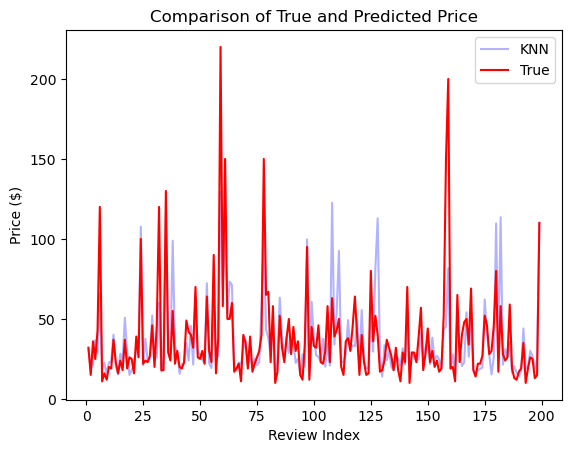

In [93]:
# Checking for prediction performance
start_id = int(input('Start Index: '))
end_id = int(input('End Index: '))

plt.plot(range(start_id, end_id, 1), knn_predictions[start_id:end_id], color='blue', alpha=0.3, label='KNN')
#plt.plot(range(start_id, end_id, 1), rf_predictions[start_id:end_id], color='green', alpha=0.3, label='RF')
#plt.plot(range(start_id, end_id, 1), ridge_predictions[start_id:end_id], color='purple', alpha=0.3, label='Ridge')
#plt.plot(range(start_id, end_id, 1), linear_predictions[start_id:end_id], color='orange', alpha=0.3, label='Linear')
plt.plot(range(start_id, end_id, 1), y_test[start_id:end_id], color='red', label='True')
plt.title(f'Comparison of True and Predicted Price')
plt.xlabel('Review Index')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [94]:
def predict_price(model, input_data):
    # Ensure the input data has the same columns as the training data
    input_df = pd.DataFrame(input_data, index=['test_data'])

    # Make predictions using the trained model
    prediction = model.predict(input_df)

    return prediction

input_data = {
    'ProRating': 95,
    'Rating': 4.1,
    'Country': 'France',
    'Region': 'Urgundy',
    'Cleaned_winenotes': 'fruity flavor, nice aroma'
}
    
predicted_prices = predict_price(knn_model, input_data)
print(predicted_prices)

[43.27571429]


The winenotes help us to separate the price of the wines very well, since depending on the ingredients the wine contains the price may vary. However, when predicting the price, characteristics such as the origin of the wine, how the experts perceive it with the score they give the wine, as well as the way the general public perceives it, are more important. The reality is that, when setting the price of wine, the producer's perspective is not so important, but rather the market's.